# Physics informed relevant information simulation (PIRIS)
**Comparación con el artículo de DFT**


# Librerias y Constantes

In [429]:
#Importamos ls librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
#np.random.seed(42)
#tf.random.set_seed(42)

In [430]:
# Parametros de creación de la muestra

a = 1.863  #Distancia de enlace Zn-O (A)
beta = 30*np.pi/180 #angulo de proyeccion de los lados del hexágono sobre el eje x en radianes
dist_x = 2*a*np.cos(beta) # distancia entre puntos en el eje x
dist_y = a*np.sin(beta) # distancia entre puntos en el eje y
offset_x = dist_x / 2 #offset de las filas impares a partir de la tercera fila
cols = 6# Número de columnas y filas
rows = 6

# Parametros del potencial L-J
kj_mol_to_ev = 0.01034 #Factor de conversion kj/mol a eV/atomo
SigmaO = 3.71 #Radio de vanderwalls del Oxigeno (A)
EpsilonO = 1.736 * kj_mol_to_ev #Fondo del pozo del Oxigeno (eV/atom)
SigmaNi = 2.834 #Radio de vanderwalls del Niquel (A)
EpsilonNi = 0.0628 *kj_mol_to_ev #Fondo del pozo Niquel (ev/atom)
SigmaZn = 4.045 #Radio de vanderwalls del Zinc (A)
EpsilonZn = 0.23 *kj_mol_to_ev #Fondo del pozo Zinc (ev/atom)
SigmaO_Ni = (SigmaO+SigmaNi)/2 #Constante sigma de interacción cruzada O-Ni 
EpsilonO_Ni = np.sqrt(EpsilonO*EpsilonNi) #Constante epsilon de interacción cruzada O-Ni 
SigmaZn_Ni = (SigmaZn+SigmaNi)/2 #Constante sigma de interacción cruzada Zn-Ni
EpsilonZn_Ni= np.sqrt(EpsilonZn*EpsilonNi) #Constante epsilon de interacción cruzada Zn-Ni 

# Parametros potencial coulomb
k_e = 14.3996 #Constante de coulomb en vacio en (eV A/e^2)
q_Ni = 2 #(carga del electron e)
q_O = -0.86 #(carga del electron e)
q_Zn = 0.86 #(carga del electron e)

# Radios de corte de intereacción basados en el potencial L-J
r_cutoffO_Ni = 2.5*SigmaO_Ni #Radio maximo de interacción Ni-O(A)
r_cutoffZn_Ni = 2.5*SigmaZn_Ni #Radio maximo de interacción Ni-Zn(A)
r_cutoffNi_Ni = 2.5*SigmaNi #Radio maximo de interacción Ni-Ni(A)

In [431]:
# Casteamos a tf los parametros
SigmaO_Ni = tf.cast(SigmaO_Ni, tf.float32)
EpsilonO_Ni = tf.cast(EpsilonO_Ni, tf.float32)
SigmaZn_Ni = tf.cast(SigmaZn_Ni, tf.float32)
EpsilonZn_Ni = tf.cast(EpsilonZn_Ni, tf.float32)
SigmaNi_Ni = tf.cast(SigmaNi, tf.float32)
EpsilonNi_Ni = tf.cast(EpsilonNi, tf.float32)
k_e = tf.cast(k_e,tf.float32)
q_Ni = tf.cast(q_Ni,tf.float32)
q_O = tf.cast(q_O,tf.float32)
q_Zn = tf.cast(q_Zn,tf.float32)
r_cutoffO_Ni = tf.cast(r_cutoffO_Ni, tf.float32)
r_cutoffZn_Ni = tf.cast(r_cutoffZn_Ni, tf.float32)
r_cutoffNi_Ni = tf.cast(r_cutoffNi_Ni, tf.float32)

# Creación de la muestra 1: ZnO en forma Grafeno

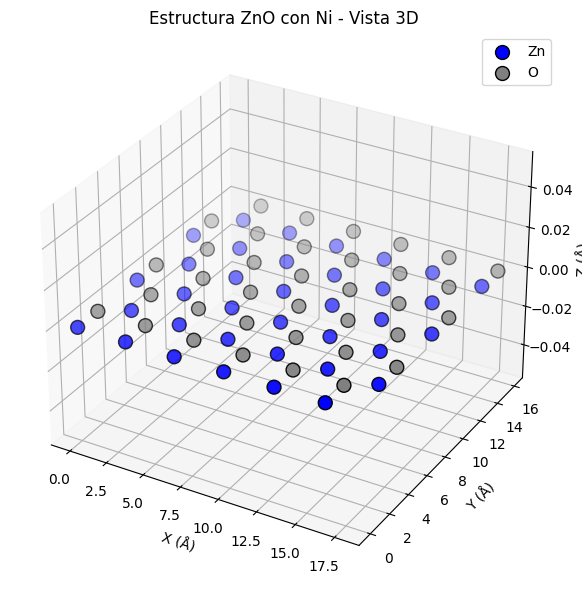

In [432]:
# Generar diccionario de coordenadas
coord_dict = {"Zn": [], "O": []}

for row in range(rows):
    y_zn = row * (a + dist_y)
    y_o = y_zn + a
    x_offset = offset_x if row % 2 == 1 else 0

    for col in range(cols):
        x = col * dist_x + x_offset
        coord_dict["Zn"].append((x, y_zn, 0))
        coord_dict["O"].append((x, y_o, 0))

positions = []
elements = []

for atom_type, coords in coord_dict.items():
    for pos in coords:
        positions.append(pos)
        elements.append(atom_type)



num_atoms = len(positions)
positions = np.array(positions)
elements = np.array(elements)

colors = {"Zn": "blue", "O": "grey"}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()

# Creación de los iones que se van a adsorber

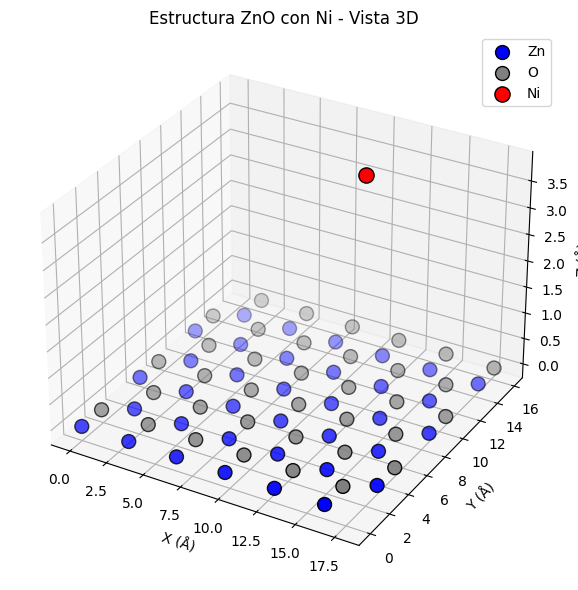

In [433]:
num_ni = 1  # número de iones Ni
z_min, z_max = 0.3 * SigmaO_Ni, 2.0 * SigmaZn_Ni  # altura en Å sobre la monocapa
radius_min, radius_max = 2.0, 5.0  # distancia lateral desde el centro

# Calcular centro de la estructura base
center = np.mean(positions, axis=0)

# Lista para almacenar posiciones de iones Ni
ni_positions = []

while len(ni_positions) < num_ni:
    direction = np.random.normal(size=2)
    direction /= np.linalg.norm(direction)
    r = np.random.uniform(radius_min, radius_max)
    x, y = center[0:2] + r * direction
    z = np.random.uniform(z_min, z_max)
    ni_positions.append([x, y, z])

ni_positions = np.array(ni_positions)


# --- Gráfica 3D Interactiva con Plotly ---
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for atom_type in set(elements):
    idx = [i for i, e in enumerate(elements) if e == atom_type]
    pos = positions[idx]
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
               color=colors.get(atom_type, "black"),
               label=atom_type, s=100, edgecolors='k')
ax.scatter(ni_positions[:, 0], ni_positions[:, 1], ni_positions[:, 2],
           color='red', label='Ni', s=120, edgecolors='k')

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Estructura ZnO con Ni - Vista 3D")
ax.legend()
plt.tight_layout()
plt.show()



# Definición del hamiltoniano y la funcion de costo

In [434]:
# Lennard-Jones potential function
@tf.function
def lennard_jones_potential(r, epsilon, sigma, q_j):
    sr6 = tf.math.pow(sigma / r, 6)
    sr12 = tf.math.pow(sr6, 2)
    lj = 4.0 * epsilon * (sr12 - sr6) + epsilon # Sumamos epsilon para dejar el fondo del pozo en 0
    coulomb = k_e * q_Ni * q_j / tf.maximum(r, 1e-10)
    return lj + coulomb

# Función de costo para el modelo
@tf.function
def H_loss(positions, elements, ni_positions,compute_correction=False):
     """
    Calcula la energía total de las interacciones entre los iones (ni_positions) y la superficie (positions),
    utilizando el potencial de Lennard-Jones.
    Parameters:
        Ni_positions: tensor con posiciones de los iones (num_iones, 3)
        Positions: tensor con posiciones de los átomos de la superficie (num_atoms, 3)
        Elements: tensor cn etiquetas de tipo de atomo (num_superficie,)
        compute_correction: define si calcular o no la correción de la energia para que el fondo del pozo sea -epsilon y no 0 (bool)
    Returns:
        Energía total del sistema (escalar)
        Energía total de cada ion (num_iones,)
        corrected_energy_total (opcional): escalar, energía total corregida (mínimo en -epsilon)
    """
    #----------------------INTERACCIONES ION-NANOESTRUCTURA-------
    # Expandir dimensiones para obtener todas las combinaciones de distancias ion-atomo
     pos_exp = tf.expand_dims(positions, axis=1)  # (num_atoms, 1, 3)
     ni_exp = tf.expand_dims(ni_positions, axis=0)  # (1, num_iones, 3)
   
     r = tf.norm(pos_exp - ni_exp, axis=2)  # Uso la norma para calcular la magnitud de la distancia 
                                # entre cada ion y cada átomo de la superficie (num_iones, num_atoms)
     
    # Casteamos las etiquetas para que tengan la forma de r
     elements_exp = tf.reshape(elements, (-1, 1))  # (num_atoms, 1)

    # Creamos una mascara para etiquetar las interacciones
     is_O = tf.equal(elements_exp, "O")
     is_Zn = tf.equal(elements_exp, "Zn")


    # Calculamos la energía aplicando cortes de distancia de interacción
     energy_O = tf.where(r < r_cutoffO_Ni,
                        lennard_jones_potential(r, EpsilonO_Ni, SigmaO_Ni,q_O),
                        tf.zeros_like(r))
     energy_Zn = tf.where(r < r_cutoffZn_Ni,
                         lennard_jones_potential(r, EpsilonZn_Ni, SigmaZn_Ni, q_Zn),
                         tf.zeros_like(r))
    # Filtramos el valor de la energía dependiendo de la etiqueta
     atoms_energy_matrix = tf.where(is_O, energy_O,
                            tf.where(is_Zn, energy_Zn, tf.zeros_like(r)))

    # Calculamos la energia promedio por ion considerando que no todos interactuan con la misma
    # cantidad de atomos.

    # Definimos mascaras para contar las interacciones validas
     mask_O = tf.cast(tf.less(r, r_cutoffO_Ni), tf.float32) * tf.cast(is_O, tf.float32)
     mask_Zn = tf.cast(tf.less(r, r_cutoffZn_Ni), tf.float32) * tf.cast(is_Zn, tf.float32)
     interaction_mask_atoms = tf.maximum(mask_O, mask_Zn)  # shape: (num_atoms, num_ions)

    # Energía total por ion (sumando sobre átomos)
     energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)  # shape: (num_ions,)
    # Número de interacciones válidas por ion
     count_per_ion = tf.reduce_sum(interaction_mask_atoms, axis=0)  # shape: (num_ions,)
     count_per_ion_safe = tf.where(count_per_ion == 0, 1.0, count_per_ion)  # evitar división por cero
    # Energia promedio de cada ion
     mean_energy_per_ion = energy_per_ion / count_per_ion_safe  # shape: (num_ions,)


    #----------------------INTERACCIONES ION-ION-------
    # Calcula matriz de vectores diferencia entre iones
     diff_ion = tf.expand_dims(ni_positions, 0) - tf.expand_dims(ni_positions, 1)  # (num_ions, num_ions, 3)
    # Calcula matriz de distancias usando norma
     r_ion = tf.norm(diff_ion, axis=-1)  # (num_ions, num_ions)

    # Construye máscaras para excluir la diagonal y aplicar cutoff
     eye = tf.eye(tf.shape(ni_positions)[0], dtype=tf.bool)  # diagonal True
     mask_offdiag = tf.logical_not(eye)  # off-diagonal True
     mask_cutoff = tf.less(r_ion, r_cutoffNi_Ni)  # True si r < cutoff
     interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)  # pares válidos distintos
    # Prepara distancias válidas evitando divisiones por cero
     valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))

    # Calcula energía Lennard-Jones solo en pares válidos
     ion_energy_matrix = tf.where(interaction_mask_ions,
                             lennard_jones_potential(valid_r, EpsilonNi_Ni, SigmaNi_Ni, q_Ni),
                             tf.zeros_like(r_ion))
    # Energías totales ion_ion
     ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)  # (num_ions,)
    # Número de interacciones válidas por ion
     count_per_ion_ion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32), axis=0)  # (num_ions,)
     count_per_ion_ion_safe = tf.where(count_per_ion_ion == 0, 1.0, count_per_ion_ion)
    # Energias promedio ion_ion
     mean_ion_ion_energy_per_ion = ion_ion_energy_per_ion / count_per_ion_ion_safe  # (num_ions,)
    
    # calcular la energía total del sistema y la energía por ion
     ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5 #Multiplico por 0.5 porque la energia aparece una vez para cada ion
     energy_total_per_ion = energy_per_ion + ion_ion_energy_per_ion
     energy_total = tf.reduce_sum(energy_per_ion)+ion_ion_total_energy
    
    # ---------------------- OPCIONAL: CORRECCIÓN ----------------------
     if compute_correction: #Solo cuando se le diga a la funcion que necesita calcular la correción
         num_interactions_O = tf.reduce_sum(tf.cast(mask_O, tf.float32))
         num_interactions_Zn = tf.reduce_sum(tf.cast(mask_Zn, tf.float32))
         num_interactions_ionion = tf.reduce_sum(tf.cast(interaction_mask_ions, tf.float32))
         total_epsilon_shift = (
             num_interactions_O * EpsilonO_Ni +
             num_interactions_Zn * EpsilonZn_Ni +
             num_interactions_ionion * EpsilonNi_Ni
         )
         corrected_energy_total = energy_total - total_epsilon_shift
         return energy_total, energy_total_per_ion, corrected_energy_total #si se calcula, retorna la energia corregida
     return  energy_total, energy_total_per_ion# si no es necesario, solo retorna la energia con minimo en 0

In [435]:
#tensorflow data
ion = tf.Variable(ni_positions,dtype=tf.float32)
sample_atoms = tf.convert_to_tensor(positions,dtype=tf.float32)
sample_elements = tf.convert_to_tensor(elements, dtype=tf.string)

In [436]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

In [437]:
# Callback class
class EarlyStoppingCallback:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True  # Signal to stop training
        return False  # Continue training

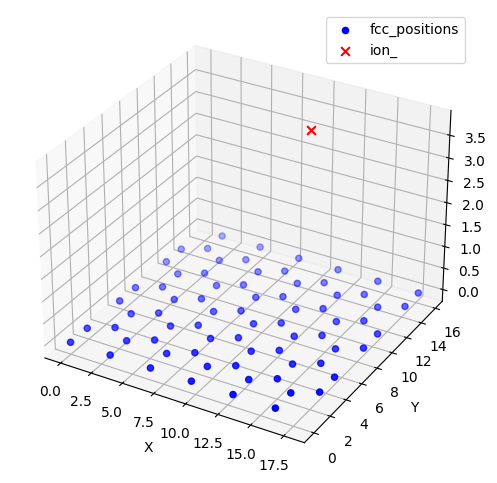

Epoch 1/500
Loss: -4.812217712402344 MeanGrad: [-0.00393963 -0.7394775   0.5885267 ]


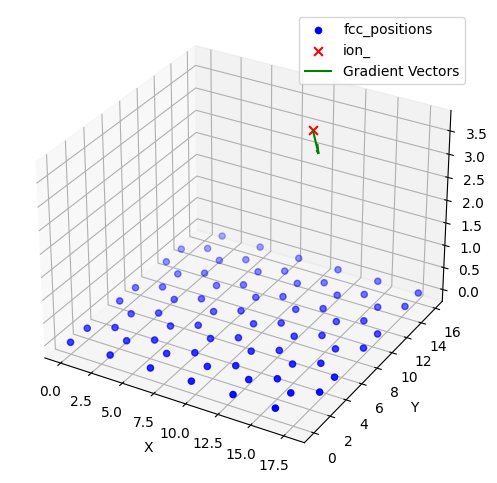

Epoch 2/500
Loss: -1.938858985900879 MeanGrad: [ 0.00924194 -1.1043165   0.4513637 ]
Epoch 3/500
Loss: -1.9543206691741943 MeanGrad: [ 0.00876081 -1.1079773   0.45475987]
Epoch 4/500
Loss: -1.9558777809143066 MeanGrad: [ 0.0086827  -1.1083446   0.45510054]
Epoch 5/500
Loss: -1.9560365676879883 MeanGrad: [ 0.0086737  -1.1083813   0.45513594]
Epoch 6/500
Loss: -1.956049919128418 MeanGrad: [ 0.00867224 -1.1083845   0.45513937]
Early stopping at epoch 6


In [438]:
ion_ =  ion.numpy()
fig = plt.figure(figsize=(6, 6))  # Adjust figure size if needed
ax = fig.add_subplot(111, projection='3d')

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

# Custom training loop
eta0 = 0.1
batch_size = 256
epochs = 500
decay_rate = 0.10
optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)
starting_pos =ion_.copy()
E_total_log = []#Para guardar y graficar la energía del sistema

early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.00001)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    optimizer.learning_rate.assign(eta)
    
    with tf.GradientTape() as g:
        g.watch(ion)
        H_loss_,ion_total_energies = H_loss(sample_atoms,sample_elements,ion)
        E_total_log.append(float(H_loss_))
    grad_ = g.gradient(H_loss_, ion)
    optimizer.apply_gradients(zip([grad_], [ion]))
    print(f'Loss: {H_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    # Call the callback's on_epoch_end method
    if early_stopping.on_epoch_end(epoch, H_loss_.numpy()):
        print(f'Early stopping at epoch {early_stopping.stopped_epoch + 1}')
        break
    if epoch%15==0:
        ion_ =  ion.numpy()
        gradN = -10*eta0*grad_.numpy()
    
    
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
    
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
        ax.scatter(ion_[:, 0], ion_[:, 1], ion_[:, 2], c='r', s=40, marker='x', label='ion_')
    
        # For quiver, we need to create a 3D representation of the gradient
        # Assuming gradN is a 2D array (num_ions, 2)
        gradN_3D = np.zeros(gradN.shape,dtype=gradN.dtype)  # Initialize with zeros for z-component
        gradN_3D = gradN  # Copy x and y components from gradN
    
        ax.quiver(ion_[:, 0], ion_[:, 1], ion_[:, 2], gradN_3D[:, 0], gradN_3D[:, 1], gradN_3D[:, 2],
                  color='g', length=1, normalize=True, label='Gradient Vectors')  # Adjust length and normalize as needed
    
        #ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        #ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        #ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
    
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
    
        plt.show()

In [439]:
#Calculamos la energía al final del entrenamiento y corregimos el desplazamiento del epsilon
full_energy, ion_total_energies, corrected_energy_total = H_loss(
    sample_atoms,  # Tensor con TODAS las posiciones de átomos de la superficie (Zn + O)
    sample_elements,   # Tensor con las etiquetas correspondientes
    ion,
    compute_correction=True  # Aquí activas la corrección de epsilon
    )
    
# Pasa a numpy para reportes
system_energy = corrected_energy_total.numpy()

In [440]:
print(f'Atomos en la muestra: {num_atoms} - Iones a adsorber: {num_ni}')
print(f'Energía total del sistema:{system_energy:.5f} ev/atom')
print(f'Energía promedio de adsorcion por ion:{system_energy/num_ni:.5f} ev/atom')
print(f"Desviación estándar de energía por ion: {tf.math.reduce_std(ion_total_energies):.5f} ev/atom") #Revisar
distance=ion_-starting_pos
mean_vector = np.mean(distance, axis=0)  # Promedio en X, Y, Z
mean_magnitude = np.mean(np.linalg.norm(distance, axis=1))
print(f'Distancia viajada promedio (vectorial): {mean_vector}')
print(f'Distancia promedio recorrida (magnitud): {mean_magnitude:.3f} Å')

Atomos en la muestra: 72 - Iones a adsorber: 1
Energía total del sistema:-2.03056 ev/atom
Energía promedio de adsorcion por ion:-2.03056 ev/atom
Desviación estándar de energía por ion: 0.00000 ev/atom
Distancia viajada promedio (vectorial): [ 0.09991932  0.09999847 -0.09999871]
Distancia promedio recorrida (magnitud): 0.173 Å


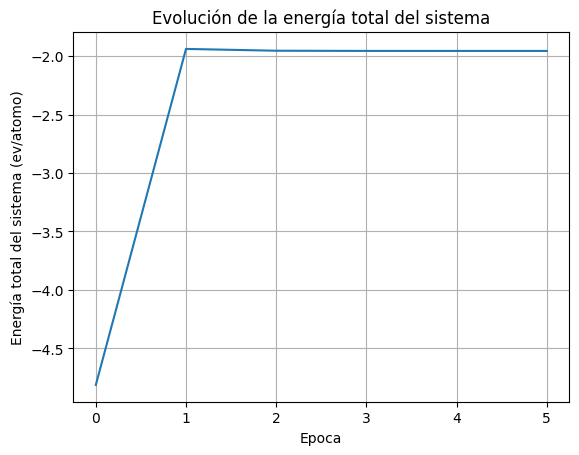

In [441]:
# --- Graficar evolución de energía total ---
import matplotlib.pyplot as plt
plt.plot(E_total_log)
plt.xlabel("Epoca")
plt.ylabel("Energía total del sistema (ev/atomo)")
plt.title("Evolución de la energía total del sistema")
plt.grid(True)
plt.show()